In [217]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
from tqdm import tqdm
import nltk

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import nltk
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [219]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexandr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alexandr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/alexandr/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [220]:
plt.style.use('seaborn-v0_8-bright')

In [221]:
try:
    data_1 = pd.read_csv('data/labeled.csv')
    data_2 = pd.read_csv('data/russian_comments_from_2ch_pikabu.csv')
    data_3 = pd.read_fwf('data/dataset.txt',header=None)
    bad_words = pd.read_csv('data/bad_words.txt', names = ['bad_words'])
except:
    print('error')

In [222]:
data_1.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [223]:
bad_words = bad_words.sort_values(by='bad_words')

In [224]:
data_3 = data_3.iloc[:,[0]]

In [225]:
def preprocessing(text):
    return text.split(" ")[0].split('__')[-1]

def preprocessing_(text):
    return " ".join(text.split(" ")[1:])

In [226]:
data_3['comment'] = data_3[0].apply(preprocessing_)
data_3['toxic'] = data_3[0].apply(preprocessing)
data_3['toxic'].unique()

array(['INSULT', 'NORMAL', 'THREAT', 'OBSCENITY'], dtype=object)

In [227]:
data_3.head()

,0,comment,toxic
0,__label__INSULT скотина! что сказать,скотина! что сказать,INSULT
1,__label__NORMAL я сегодня проезжала по рабочей...,я сегодня проезжала по рабочей и между домами ...,NORMAL
2,__label__NORMAL очередной лохотрон. зачем прид...,очередной лохотрон. зачем придумывать очередно...,NORMAL
3,__label__NORMAL ретро дежавю ... сложно понять...,"ретро дежавю ... сложно понять чужое сердце , ...",NORMAL
4,__label__NORMAL а когда мы статус агрогородка ...,а когда мы статус агрогородка получили?,NORMAL


In [228]:
data_3_ = data_3.loc[data_3['toxic']=='INSULT']
data_3_n = data_3.loc[data_3['toxic']=='NORMAL']
data_3_ = data_3_.drop([0], axis=1)
data_3_n = data_3_n.drop([0], axis=1)
data_3_['toxic'] = 1
data_3_n['toxic'] = 0

In [229]:
data_3 = pd.concat([data_3_, data_3_n], axis=0)

In [230]:
data = pd.concat([data_1, data_3], axis=0)
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [231]:
data['toxic'].value_counts(normalize=True)

toxic
0.0    0.864622
1.0    0.135378
Name: proportion, dtype: float64

In [232]:
no_toxic=data['toxic'].value_counts('any')[0]
yes_toxic=data['toxic'].value_counts('any')[1]
data['toxic'].value_counts('any')

toxic
0.0    0.864622
1.0    0.135378
Name: proportion, dtype: float64

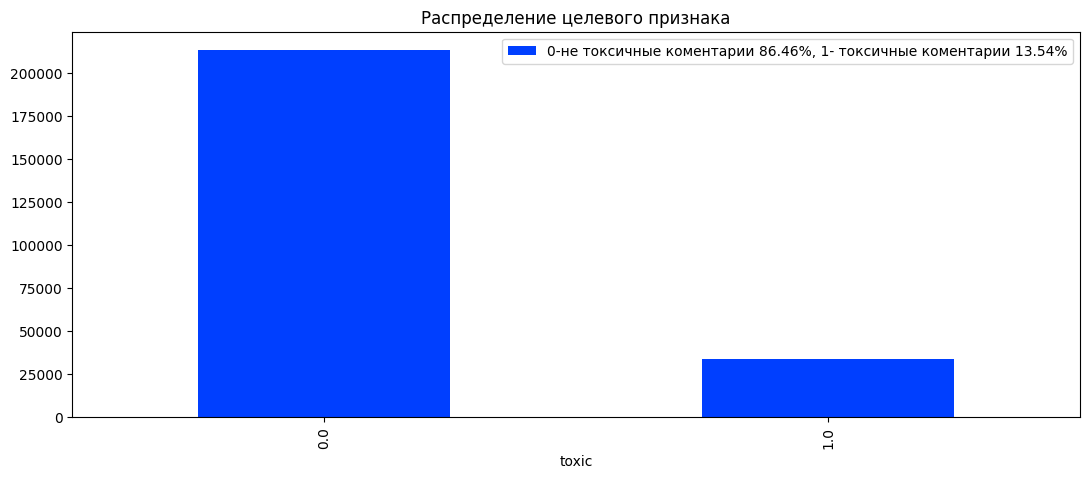

In [233]:
plt.figure(figsize=(13, 5))
data['toxic'].value_counts().plot(kind='bar',label=f'0-не токсичные коментарии {no_toxic:.2%}, 1- токсичные коментарии {yes_toxic:.2%}')
plt.title('Распределение целевого признака')
plt.legend(loc="upper right")
plt.show();

In [234]:
data.duplicated().sum()
data.drop_duplicates(inplace=True)

In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246647 entries, 0 to 248289
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   comment  246647 non-null  object 
 1   toxic    246647 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.6+ MB


In [236]:
data['toxic'] = data['toxic'].astype('int8')

In [237]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246647 entries, 0 to 248289
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   comment  246647 non-null  object
 1   toxic    246647 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 4.0+ MB


# Preprocessing

In [238]:
def clear_text(text):
    text=re.sub(r"[^а-яА-Я']", ' ', text.lower())
    text=" ".join(text.split())
    return text

In [239]:
data['comment_clear_text'] = data['comment'].apply(clear_text)

In [240]:
data.head()

,comment,toxic,comment_clear_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1,верблюдов то за что дебилы бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1,хохлы это отдушина затюканого россиянина мол в...
2,Собаке - собачья смерть\n,1,собаке собачья смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1,страницу обнови дебил это тоже не оскорбление ...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1,тебя не убедил страничный пдф в том что скрипа...


In [241]:
stop_words = set(nltk.corpus.stopwords.words('russian'))
def without_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

In [242]:
data['comment_without_stop_words'] = data['comment_clear_text'].apply(without_stopwords)

In [243]:
def steming(text):
    m = nltk.stem.SnowballStemmer('russian')
    word_list = nltk.word_tokenize(text)
    
    return ' '.join(m.stem(w) for w in word_list)

In [244]:
data['comment_steming'] = data['comment_clear_text'].apply(steming)

In [245]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    NamesExtractor,
    Doc,
)

In [246]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

In [247]:
def lemmitizer(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    return ' '.join(x.lemma for x in doc.tokens)

In [248]:
data['comment_lemmitizer'] = data['comment_clear_text'].apply(lemmitizer)

In [249]:
data.head()

,comment,toxic,comment_clear_text,comment_without_stop_words,comment_steming,comment_lemmitizer
0,"Верблюдов-то за что? Дебилы, бл...\n",1,верблюдов то за что дебилы бл,верблюдов дебилы бл,верблюд то за что дебил бл,верблюд тот за что дебил бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1,хохлы это отдушина затюканого россиянина мол в...,хохлы это отдушина затюканого россиянина мол в...,хохл эт отдушин затюкан россиянин мол вон а у ...,хохол это отдушина затюканый россиянин мол вон...
2,Собаке - собачья смерть\n,1,собаке собачья смерть,собаке собачья смерть,собак собач смерт,собака собачий смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1,страницу обнови дебил это тоже не оскорбление ...,страницу обнови дебил это оскорбление доказанн...,страниц обнов деб эт тож не оскорблен а доказа...,страница обнови дебил это тоже не оскорбление ...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1,тебя не убедил страничный пдф в том что скрипа...,убедил страничный пдф скрипалей отравила росси...,теб не убед страничн пдф в том что скрипал отр...,ты не убедить страничный пдф в тот что скрипал...


In [250]:
data.head()

,comment,toxic,comment_clear_text,comment_without_stop_words,comment_steming,comment_lemmitizer
0,"Верблюдов-то за что? Дебилы, бл...\n",1,верблюдов то за что дебилы бл,верблюдов дебилы бл,верблюд то за что дебил бл,верблюд тот за что дебил бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1,хохлы это отдушина затюканого россиянина мол в...,хохлы это отдушина затюканого россиянина мол в...,хохл эт отдушин затюкан россиянин мол вон а у ...,хохол это отдушина затюканый россиянин мол вон...
2,Собаке - собачья смерть\n,1,собаке собачья смерть,собаке собачья смерть,собак собач смерт,собака собачий смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1,страницу обнови дебил это тоже не оскорбление ...,страницу обнови дебил это оскорбление доказанн...,страниц обнов деб эт тож не оскорблен а доказа...,страница обнови дебил это тоже не оскорбление ...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1,тебя не убедил страничный пдф в том что скрипа...,убедил страничный пдф скрипалей отравила росси...,теб не убед страничн пдф в том что скрипал отр...,ты не убедить страничный пдф в тот что скрипал...


In [251]:
data['comment_lemmitizer'].head()

0                          верблюд тот за что дебил бл
1    хохол это отдушина затюканый россиянин мол вон...
2                                собака собачий смерть
3    страница обнови дебил это тоже не оскорбление ...
4    ты не убедить страничный пдф в тот что скрипал...
Name: comment_lemmitizer, dtype: object

In [252]:
bad_words = bad_words['bad_words'].values

In [253]:
bad_words

array(['spam', 'аборт', 'анус', ..., 'шмара', 'шмарить', 'шмариться'],
      dtype=object)

In [254]:
def bad_words_in_list(text):
    if [word for word in text.split() if word in bad_words]:
        return True
    return False

In [255]:
data['comment_with_bad_words'] = data['comment_lemmitizer'].apply(bad_words_in_list)

In [256]:
data.head()

,comment,toxic,comment_clear_text,comment_without_stop_words,comment_steming,comment_lemmitizer,comment_with_bad_words
0,"Верблюдов-то за что? Дебилы, бл...\n",1,верблюдов то за что дебилы бл,верблюдов дебилы бл,верблюд то за что дебил бл,верблюд тот за что дебил бл,False
1,"Хохлы, это отдушина затюканого россиянина, мол...",1,хохлы это отдушина затюканого россиянина мол в...,хохлы это отдушина затюканого россиянина мол в...,хохл эт отдушин затюкан россиянин мол вон а у ...,хохол это отдушина затюканый россиянин мол вон...,False
2,Собаке - собачья смерть\n,1,собаке собачья смерть,собаке собачья смерть,собак собач смерт,собака собачий смерть,False
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1,страницу обнови дебил это тоже не оскорбление ...,страницу обнови дебил это оскорбление доказанн...,страниц обнов деб эт тож не оскорблен а доказа...,страница обнови дебил это тоже не оскорбление ...,False
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1,тебя не убедил страничный пдф в том что скрипа...,убедил страничный пдф скрипалей отравила росси...,теб не убед страничн пдф в том что скрипал отр...,ты не убедить страничный пдф в тот что скрипал...,False


In [257]:
sum(data['toxic']==True)

33393

In [258]:
TP = (data[(data['toxic'] == True) & (data['comment_with_bad_words']==True)])['toxic'].count()
TN = (data[(data['toxic'] == False) & (data['comment_with_bad_words']==True)])['toxic'].count()
FP = (data[(data['toxic'] == False) & (data['comment_with_bad_words']==True)])['toxic'].count()
FN = (data[(data['toxic'] == True) & (data['comment_with_bad_words']==False)])['toxic'].count()

In [259]:
Recall = TP/(TP+FN)
Precision = TP/(TP+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
F1

0.607804167732541

In [260]:
final_result={}
final_result['model_only_badword_in_token']=F1

In [261]:
final_result

{'model_only_badword_in_token': 0.607804167732541}

# TRAIN

In [262]:
X_steming = data['comment_steming'].values.astype('U')
X_lemmitizer = data['comment_lemmitizer'].values.astype('U')
y = data['toxic']

In [263]:
#Разделим даные 80/20, перекрестная проверка 5*2
X_train_steming,X_test_steming,y_train,y_test=train_test_split(X_steming,y,
                                               test_size=0.2,
                                              random_state=42,
                                              stratify=y)

In [264]:
X_train_lemmitizer,X_test_lemmitizer,y_train,y_test=train_test_split(X_lemmitizer,y,
                                               test_size=0.2,
                                              random_state=42,
                                              stratify=y)

In [265]:
count_tf_idf_steming = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,1))
count_tf_id_lemmitizer = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,1))

In [266]:
X_train_tf_idf_steming = count_tf_idf_steming.fit_transform(X_train_steming)
X_test_tf_idf_steming = count_tf_idf_steming.transform(X_test_steming)

In [267]:
X_train_tf_idf_lemmitizer = count_tf_id_lemmitizer.fit_transform(X_train_lemmitizer)
X_test_tf_idf_lemmitizer = count_tf_id_lemmitizer.transform(X_test_lemmitizer)

In [268]:
for i in (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, SGDClassifier):
    print(i(random_state=42,class_weight='balanced'))

LogisticRegression(class_weight='balanced', random_state=42)
DecisionTreeClassifier(class_weight='balanced', random_state=42)
RandomForestClassifier(class_weight='balanced', random_state=42)
SGDClassifier(class_weight='balanced', random_state=42)


In [269]:
def piplene_(data_train_stem,data_train_lem, data_text_stem, data_test_lem, y_train,y_test, random_state=42, class_weight='balanced'):
    result = {}
    models = (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, SGDClassifier)
    for model in tqdm(models):
        model_stem=model(random_state = random_state, class_weight=class_weight)
        model_stem.fit(data_train_stem,y_train)
        predictions=model_stem.predict(data_text_stem)
        result_f1 = f1_score(y_test, predictions)
        result[f'{model_stem.__class__.__name__}_steming']=result_f1
        model_lem = model(random_state = random_state, class_weight=class_weight)
        model_lem.fit(data_train_lem,y_train)
        predictions=model_lem.predict(data_test_lem)
        result_f1 = f1_score(y_test, predictions)
        result[f'{model_lem.__class__.__name__}_lemmatizing']=result_f1
    return result
        

In [270]:
result = piplene_(
    data_train_stem=X_train_tf_idf_steming,
    data_train_lem=X_train_tf_idf_lemmitizer,
    data_text_stem=X_test_tf_idf_steming,
    data_test_lem=X_test_tf_idf_lemmitizer,
    y_train=y_train,
    y_test=y_test,
    random_state=42,
    class_weight='balanced',
    )


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [28:29<00:00, 427.30s/it]


In [271]:
final_result = {**result,**final_result}

In [272]:
data_result=pd.DataFrame.from_dict(final_result, orient='index', columns=['F1']).sort_values('F1', ascending=False)
data_result

,F1
LogisticRegression_steming,0.842714
SGDClassifier_steming,0.832508
LogisticRegression_lemmatizing,0.827766
RandomForestClassifier_steming,0.819532
RandomForestClassifier_lemmatizing,0.817197
SGDClassifier_lemmatizing,0.809935
DecisionTreeClassifier_steming,0.779478
DecisionTreeClassifier_lemmatizing,0.777514
model_only_badword_in_token,0.607804


# Вывод:

- Лучшая модель c параметрами по умолчанию: LogisticRegression_steming, SGDClassifier_steming
- При использовании процесса предобработки текста стминг, получено лучше результаты чем при использовании леммитизации увсех использеумых моделей. 
- Стемин имеет меньшую вычислительную сложность чем лемитизация.
- Использовании в простых моделей процесса предобработки стемминг предпочтительно.
- модель model_only_badword_in_token показала еффективность болеее 0,5, но требующая значительных вычислительных затран для предобработки.
- В дальнейшем использовать две модеди для подбора гиперпараметров  с использованием GridSearchCV.
- Полученную модель обучить и использовать для классификации новых данных с поледующем обучением на всей выборке, или использовать метод .partial_fit.

In [273]:
model=LogisticRegression(random_state=42,class_weight='balanced')
parameters = [{'solver': ['saga']},
              {'penalty':['l2']},
              {'C':[0.1, 1, 10, 15, 50]}]
CV_LR = GridSearchCV(model,parameters,
                  n_jobs=-1, 
                  scoring = 'f1',
                  cv=2,
                  verbose=1)

CV_LR.fit(X_train_tf_idf_steming, y_train)  
scores = cross_val_score(CV_LR,X_train_tf_idf_steming,y_train,scoring ='f1', cv = 2)
predictions=CV_LR.predict(X_test_tf_idf_steming)
result_f1 = f1_score(y_test, predictions)
print(f'Точность перекрестной проверки:{np.mean(scores):.3f}+/-{np.std(scores):.3f}')
print(f'{model.__class__.__name__} F1:{result_f1:.3f}')

Fitting 2 folds for each of 7 candidates, totalling 14 fits
Fitting 2 folds for each of 7 candidates, totalling 14 fits
Fitting 2 folds for each of 7 candidates, totalling 14 fits
Точность перекрестной проверки:0.835+/-0.000
LogisticRegression F1:0.850


In [274]:
CV_LR.best_params_

{'C': 15}

In [276]:
model = SGDClassifier(random_state=42,class_weight='balanced')
parameters = {
    'loss':['hinge', 'log_loss', 'epsilon_insensitive'],
    'max_iter':[100, 150, 300],
    'alpha':[0.00001,0.0001,0.001],
    }
CV_SGD = GridSearchCV(model,parameters ,n_jobs=-1, scoring = 'f1',cv=2, verbose=1)
CV_SGD.fit(X_train_tf_idf_steming,y_train)
scores = cross_val_score(CV_SGD,X_train_tf_idf_steming,y_train,scoring ='f1', cv = 2)
predictions=CV_SGD.predict(X_test_tf_idf_steming)
result_f1 = f1_score(y_test, predictions)
print(f'Точность перекрестной проверки:{np.mean(scores):.3f}+/-{np.std(scores):.3f}')
print(f'F1 на тестовой выборке: {result_f1:.3f}')

Fitting 2 folds for each of 27 candidates, totalling 54 fits


Fitting 2 folds for each of 27 candidates, totalling 54 fits
Fitting 2 folds for each of 27 candidates, totalling 54 fits
Точность перекрестной проверки:0.836+/-0.003
F1 на тестовой выборке: 0.854


In [ ]:
CV_SGD.best_params_

{'alpha': 1e-05, 'loss': 'hinge', 'max_iter': 100}

# В последующем лучюую модель можно использовать для классификации текста.

In [277]:
def piplene_main(text):
    text = clear_text(text)
    text = without_stopwords(text)
    text = [steming(text)]
    result = count_tf_idf_steming.transform(text)
    return result


In [287]:
text = 'Пример текста обработки'
x = piplene_main(text)
CV_SGD.predict(x)

array([0], dtype=int8)

In [288]:
CV_LR.predict_proba(x)

array([[0.98332526, 0.01667474]])

In [300]:
text = 'гнида это насекомое'
x = piplene_main(text)
CV_SGD.predict(x)

array([1], dtype=int8)

In [301]:
CV_LR.predict_proba(x)

array([[4.38562304e-04, 9.99561438e-01]])